# CLAHE-Based Histogram Equalization for Mammogram Preprocessing

This notebook demonstrates the application of Contrast Limited Adaptive Histogram Equalization (CLAHE) to mammogram images to improve contrast and enhance visibility of relevant features. CLAHE is explored as a preprocessing step for training convolutional neural networks (CNNs) on mammographic data. 

The notebook includes:
- Application of CLAHE using OpenCV.
- Visualization of original vs enhanced images.
- Integration of CLAHE into PyTorch transforms.
- Preparation of images for model training with augmentation and normalization.

Note: This notebook was designed for exploratory testing on a local directory of images.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
import random

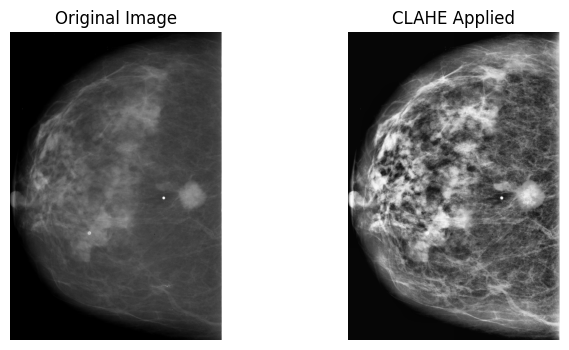

In [ ]:
# Load the image
img_path = "mammogram-ai-project/Data/Data png cropped/Mass-Training-png-cropped/images/Mass-Training_P_00753_RIGHT_CC_FULL.png"
image = cv2.imread(img_path)

# Check if the image is loaded properly
if image is None:
    print("Error: Could not read image!")
else:
    # Convert to grayscale
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10,10))  # Adjust tileGridSize if needed
    final_img = clahe.apply(image_bw)

    # Apply simple thresholding for comparison
    _, ordinary_img = cv2.threshold(image_bw, 70, 255, cv2.THRESH_BINARY)

    # Display using matplotlib (better compatibility)
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(image_bw, cmap='gray')
    axes[0].set_title("Original Image")
    
    axes[1].imshow(final_img, cmap='gray')
    axes[1].set_title("CLAHE Applied")

    #axes[2].imshow(ordinary_img, cmap='gray')
    #axes[2].set_title("Ordinary Thresholding")

    for ax in axes:
        ax.axis("off")

    plt.show()


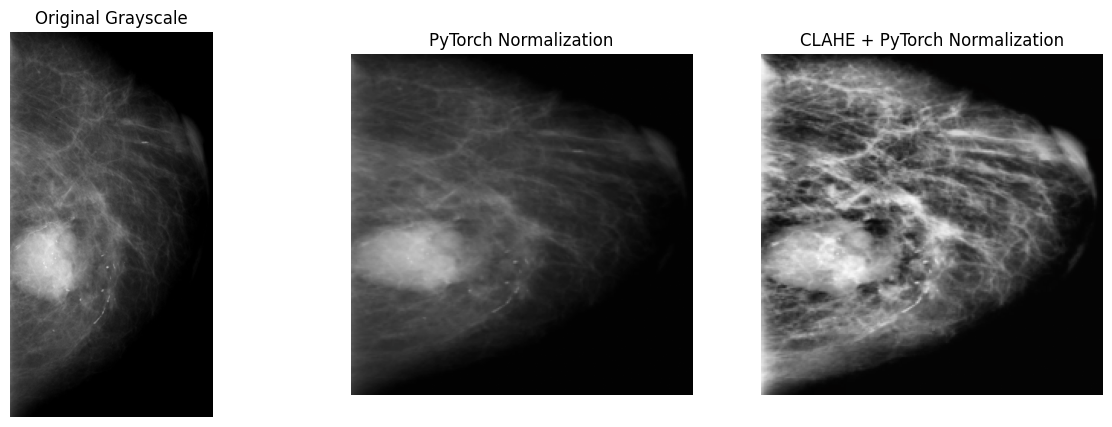

In [ ]:
# Load the image
img_path = "/Users/giulia/Desktop/EXETER/ECM3401 Dissertation Project/Code (local)/Data png cropped/Mass-Training-png-cropped/images/Mass-Training_P_01434_LEFT_CC_FULL.png"
image = cv2.imread(img_path)

# Check if the image is loaded properly
if image is None:
    print("Error: Could not read image!")
else:
    # Convert to grayscale
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))  
    image_clahe = clahe.apply(image_bw)

    # Convert CLAHE image to 3-channel grayscale (for DenseNet compatibility)
    image_clahe = cv2.merge([image_clahe, image_clahe, image_clahe])

    # Convert OpenCV (NumPy) images to PIL
    pil_original = Image.fromarray(cv2.merge([image_bw, image_bw, image_bw]))  # Original as 3 channels
    pil_clahe = Image.fromarray(image_clahe)

    # Define PyTorch transformations (Normalization for DenseNet)
    transform_pipeline = transforms.Compose([
        transforms.Resize((224, 224)),  # Ensure H, W ≥ 224
        #transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
        #T.RandomRotation(degrees=15),  # Random rotation within ±15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness & contrast
        transforms.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Apply transformations
    tensor_original = transform_pipeline(pil_original)
    tensor_clahe = transform_pipeline(pil_clahe)

    # Convert tensors back to NumPy for visualization
    def denormalize(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean  # Reverse normalization

    # Convert tensors to NumPy format (denormalized for visualization)
    image_normalized = denormalize(tensor_original).permute(1, 2, 0).numpy()
    image_clahe_normalized = denormalize(tensor_clahe).permute(1, 2, 0).numpy()

    # Plot comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_bw, cmap='gray')
    axes[0].set_title("Original Grayscale")

    axes[1].imshow(image_normalized)
    axes[1].set_title("PyTorch Normalization")

    axes[2].imshow(image_clahe_normalized)
    axes[2].set_title("CLAHE + PyTorch Normalization")

    for ax in axes:
        ax.axis("off")

    plt.show()


In [ ]:
# Custom CLAHE Transform
class ApplyCLAHE:
    """
    Custom PyTorch-compatible transform for applying CLAHE to an image.

    Args:
        clip_limit (float): Threshold for contrast limiting.
        tile_grid_size (tuple): Size of the grid for histogram equalization.
        p (float): Probability of applying CLAHE.
    """
    def __init__(self, clip_limit=5.0, tile_grid_size=(8,8), p=1.0):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        self.p = p  # Probability of applying CLAHE

    def __call__(self, img):
        if random.random() < self.p:  # Apply CLAHE with probability p
            img_np = np.array(img)  # Convert PIL to NumPy
            img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
            img_clahe = clahe.apply(img_gray)

            # Convert back to 3-channel grayscale (DenseNet expects 3 channels)
            img_clahe = cv2.merge([img_clahe, img_clahe, img_clahe])
            return Image.fromarray(img_clahe)  # Convert back to PIL
        return img

# Define transformations with CLAHE
transform_pipeline = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure H, W ≥ 224
    #transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip with 50% probability
    #T.RandomRotation(degrees=15),  # Random rotation within ±15 degrees
    ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Ensure CLAHE is always applied for test images
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Random brightness & contrast
    transforms.ToTensor(),  # Converts [0,255] uint8 → [0,1] float32
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    ApplyCLAHE(clip_limit=5.0, tile_grid_size=(8,8), p=1.0),  # Ensure CLAHE is always applied for test images
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.2021, 0.2021, 0.2021], std=[0.2519, 0.2519, 0.2519])  
])
